In [3]:
import PIL
import numpy as np
import torch
from models.models import deit_small_patch16_224

## Load ViT 

In [4]:
# lets load the model with pretrained weights learned on ImageNet dataset
model = deit_small_patch16_224(pretrained=True)
if torch.cuda.is_available(): # use gpu if available
    model = model.cuda()

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /home/u20020019/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth


  0%|          | 0.00/84.2M [00:00<?, ?B/s]

In [10]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn

## Prepare Input

(Height, width): (1920, 1229)


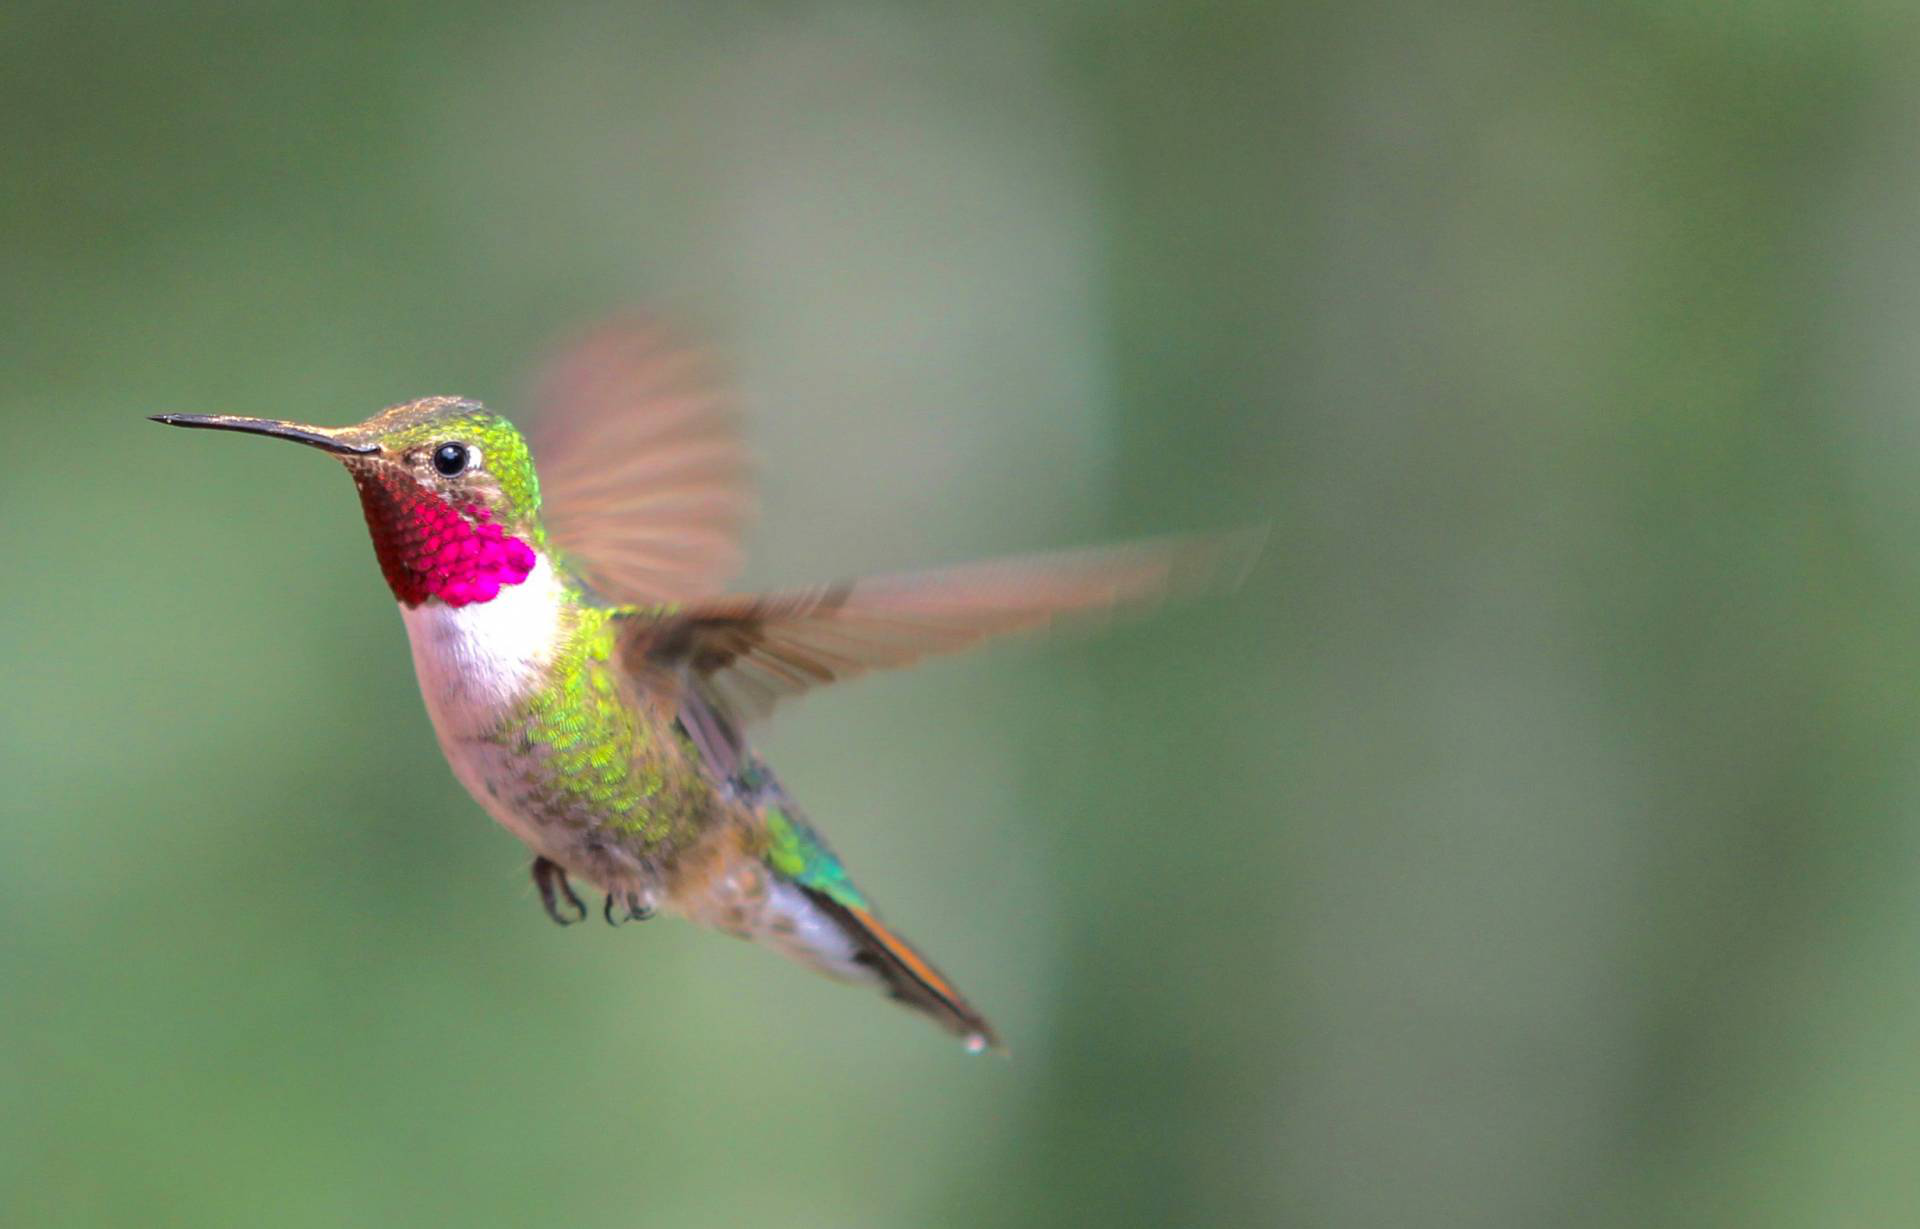

In [6]:
# lets see what model thinks about a given image
# first read the image
image = PIL.Image.open('./IMG_9127.jpg')
# check dimensions
print('(Height, width):',  image.size)
image

(Height, width): (224, 224)


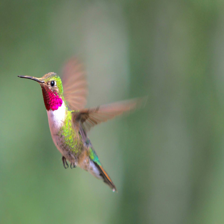

In [7]:
# Our model is trained to accept image of size (Height, width): (224, 224)
# lets fix that
image = image.resize((224,224))
print('(Height, width):',  image.size)
image

In [8]:
# Our model takes torch tensor
# lets fix that

# convert image into numpy array first
image = np.array(image)
# convert to torch tensor
image = torch.from_numpy(image).float()
print(type(image), image.shape)

<class 'torch.Tensor'> torch.Size([224, 224, 3])


### From numpy to torch

In [9]:
# Our model takes channel first, lets use transpose to fix that
image = torch.transpose(image, 1,2)
print(image.shape)
image = torch.transpose(image, 0,1)
print(image.shape) # Now the tensor is in correct shape
# finally, we need to expand the tensor for batch dimension
image = image.unsqueeze(0)
print(image.shape)

if torch.cuda.is_available(): # use gpu if available
    image = image.cuda()

torch.Size([224, 3, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


## ViT Prediction

In [11]:
# Lets see what our model think of the image but before that we need to normalize the input as well.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] - mean[0])/std[0]
    t[:, 1, :, :] = (t[:, 1, :, :] - mean[1])/std[1]
    t[:, 2, :, :] = (t[:, 2, :, :] - mean[2])/std[2]
    return t
output = model(normalize(image/255))
print(output.shape)

torch.Size([1, 1000])


In [12]:
# Its a vector of 1000 classes, we will pick the once where the model reponse is hihger than everyother class
prediction = output.argmax(dim=1)
print(prediction) # model think its class number 94, which is hummingbird
# see label to class mapping here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

tensor([94], device='cuda:0')


In [13]:
# ViT model (small) has 12 block (Transformer encoder) and each block produces a class token and patches
# Final class token produceed by a ViT model is feed into the classifier.
print('Number of Transformer encoder:', len(model.blocks))
# Lets observe the classifer
print(model.head)
# It takes 384 (class token) and project it into 1000 classes.
# In next part, we will remove this head and retrain it on CUB dataset to transfer ViT features.

Number of Transformer encoder: 12
Linear(in_features=384, out_features=1000, bias=True)


# ViT model (small) has 12 block (Transformer encoder) and each block produces a class token and patches
# Final class token produceed by a ViT model is feed into the classifier.
print('Number of Transformer encoder:', len(model.blocks))
# Lets observe the classifer
print(model.head)
# It takes 384 (class token) and project it into 1000 classes.
# In next part, we will remove this head and retrain it on CUB dataset to transfer ViT features.

In [87]:
# Lets see what our model think of the image but before that we need to normalize the input as well.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] - mean[0])/std[0]
    t[:, 1, :, :] = (t[:, 1, :, :] - mean[1])/std[1]
    t[:, 2, :, :] = (t[:, 2, :, :] - mean[2])/std[2]
    return t
output = model(normalize(image/255))
print(output.shape)

torch.Size([1, 1000])


In [88]:
# Its a vector of 1000 classes, we will pick the once where the model reponse is hihger than everyother class
prediction = output.argmax(dim=1)
print(prediction) # model think its class number 94, which is hummingbird
# see label to class mapping here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

tensor([94], device='cuda:0')


In [89]:
# ViT model (small) has 12 block (Transformer encoder) and each block produces a class token and patches
# Final class token produceed by a ViT model is feed into the classifier.
print('Number of Transformer encoder:', len(model.blocks))
# Lets observe the classifer
print(model.head)
# It takes 384 (class token) and project it into 1000 classes.
# In next part, we will remove this head and retrain it on CUB dataset to transfer ViT features.

Number of Transformer encoder: 12
Linear(in_features=384, out_features=1000, bias=True)
